# Data Preparation

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os

# convert string to integer
def atoi(s):
    n = 0
    for i in s:
        n = n*10 + ord(i) - ord("0")
    return n

# making folders
outer_names = ['test','train']
# original = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
inner_names = ['angry', 'happy', 'sad', 'calm']
os.makedirs('data', exist_ok=True)
for outer_name in outer_names:
    os.makedirs(os.path.join('data',outer_name), exist_ok=True)
    for inner_name in inner_names:
        os.makedirs(os.path.join('data',outer_name,inner_name), exist_ok=True)

# to keep count of each category
angry = 0
happy = 0
sad = 0
calm = 0
angry_test = 0
happy_test = 0
sad_test = 0
calm_test = 0

df = pd.read_csv('/content/fer_updated_2.csv')
mat = np.zeros((48,48),dtype=np.uint8)

In [2]:
# trainign vs test size
len(df[df['Usage']=='Training']), len(df[df['Usage']!='Training'])

(21005, 5212)

In [82]:
# delete folder in colab
# %rm -rf data

In [59]:
# angry,happy,sad,calm,angry_test,happy_test,sad_test,calm_test

In [4]:
# read the csv file line by line
for i in tqdm(range(len(df))):
    txt = df['pixels'][i]
    words = txt.split()

    # the image size is 48x48
    for j in range(2304):
        xind = j // 48
        yind = j % 48
        mat[xind][yind] = atoi(words[j])

    img = Image.fromarray(mat)

    # train
    if i < 21005: #28709 full dataset
        if df['emotion'][i] == 0:
            img.save('/content/data/train/angry/im'+str(angry)+'.png')
            angry += 1
        # elif df['emotion'][i] == 1:
        #     img.save('train/disgusted/im'+str(disgusted)+'.png')
        #     disgusted += 1
        # elif df['emotion'][i] == 2:
        #     img.save('train/fearful/im'+str(fearful)+'.png')
        #     fearful += 1
        elif df['emotion'][i] == 1:
            img.save('/content/data/train/happy/im'+str(happy)+'.png')
            happy += 1
        elif df['emotion'][i] == 2:
            img.save('/content/data/train/sad/im'+str(sad)+'.png')
            sad += 1
        # elif df['emotion'][i] == 5:
        #     img.save('train/surprised/im'+str(surprised)+'.png')
        #     surprised += 1
        elif df['emotion'][i] == 3:
            img.save('/content/data/train/calm/im'+str(calm)+'.png')
            calm += 1

    # test
    else:
        if df['emotion'][i] == 0:
            img.save('/content/data/test/angry/im'+str(angry_test)+'.png')
            angry_test += 1
        # elif df['emotion'][i] == 1:
        #     img.save('test/disgusted/im'+str(disgusted_test)+'.png')
        #     disgusted_test += 1
        # elif df['emotion'][i] == 2:
        #     img.save('test/fearful/im'+str(fearful_test)+'.png')
        #     fearful_test += 1
        elif df['emotion'][i] == 1:
            img.save('/content/data/test/happy/im'+str(happy_test)+'.png')
            happy_test += 1
        elif df['emotion'][i] == 2:
            img.save('/content/data/test/sad/im'+str(sad_test)+'.png')
            sad_test += 1
        # elif df['emotion'][i] == 5:
        #     img.save('test/surprised/im'+str(surprised_test)+'.png')
        #     surprised_test += 1
        elif df['emotion'][i] == 3:
            img.save('/content/data/test/calm/im'+str(calm_test)+'.png')
            calm_test += 1

print("Done!")

100%|██████████| 26217/26217 [01:22<00:00, 316.05it/s]

Done!


# Model Training

In [5]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
# # command line argument
# ap = argparse.ArgumentParser()
# ap.add_argument("--mode",help="train/display")
# mode = ap.parse_args().mode

In [21]:
# plots accuracy and loss curves
def plot_model_history(model_history):

    'Plot Accuracy and Loss curves with the model_history'

    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

In [8]:
# Define data generators
train_dir = '/content/data/train'
val_dir = '/content/data/test'

num_train = 21005
num_val = 5212
batch_size = 64
num_epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


# Train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)

Found 21008 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


Epoch 1/50


<ipython-input-8-a1e7196e7d96>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info = model.fit_generator(


328/328 [==============================] - 25s 38ms/step - loss: 1.2826 - accuracy: 0.4042 - val_loss: 1.1216 - val_accuracy: 0.5212
Epoch 2/50
328/328 [==============================] - 11s 35ms/step - loss: 1.0716 - accuracy: 0.5355 - val_loss: 0.9699 - val_accuracy: 0.5866
Epoch 3/50
328/328 [==============================] - 11s 33ms/step - loss: 0.9729 - accuracy: 0.5859 - val_loss: 0.9257 - val_accuracy: 0.6009
Epoch 4/50
328/328 [==============================] - 11s 34ms/step - loss: 0.9158 - accuracy: 0.6109 - val_loss: 0.8757 - val_accuracy: 0.6244
Epoch 5/50
328/328 [==============================] - 11s 32ms/step - loss: 0.8657 - accuracy: 0.6378 - val_loss: 0.8473 - val_accuracy: 0.6412
Epoch 6/50
328/328 [==============================] - 11s 34ms/step - loss: 0.8365 - accuracy: 0.6517 - val_loss: 0.8353 - val_accuracy: 0.6518
Epoch 7/50
328/328 [==============================] - 11s 34ms/step - loss: 0.8060 - accuracy: 0.6673 - val_loss: 0.8192 - val_accuracy: 0.6566
Epo

In [32]:
model.save_weights('model_weights_training.h5')
model.save('model_new_training.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


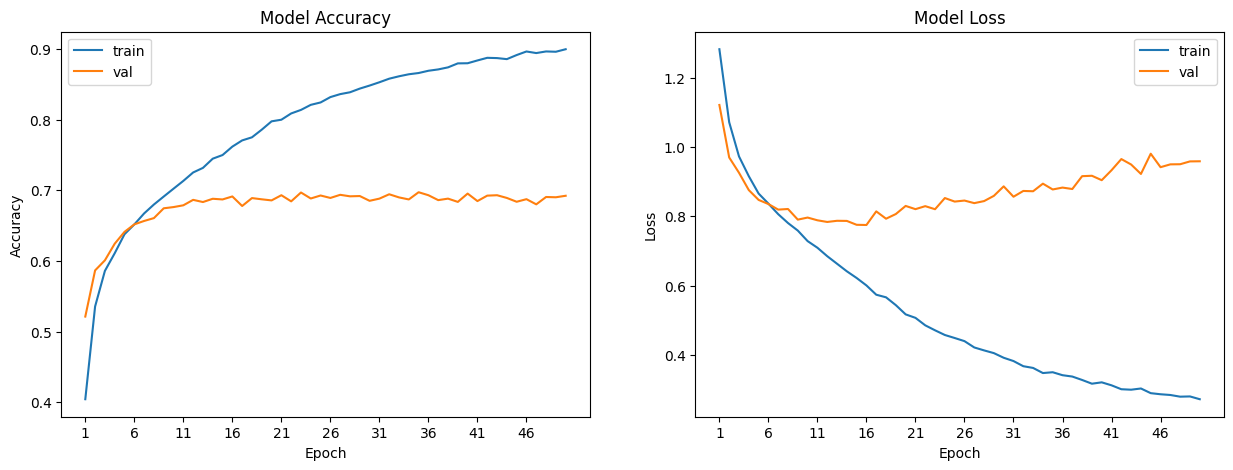

In [22]:
plot_model_history(model_info)

In [29]:
model_history_df = pd.DataFrame(model_info.history)
model_history_df

,loss,accuracy,val_loss,val_accuracy
0,1.282575,0.404173,1.121551,0.521219
1,1.071649,0.535523,0.969897,0.586613
2,0.972928,0.585943,0.925722,0.600887
3,0.915788,0.610915,0.875669,0.624421
4,0.865699,0.637844,0.847272,0.641204
5,0.836519,0.651738,0.835330,0.651813
6,0.806045,0.667303,0.819237,0.656636
7,0.780456,0.679956,0.821003,0.660687
8,0.758612,0.691224,0.790299,0.674576
9,0.728236,0.702349,0.796281,0.676312


In [30]:
# model_history_df.to_csv('model_history.csv')

In [31]:
index_where_equal = (model_history_df['loss'] - model_history_df['val_loss']).abs().idxmin()
index_where_equal

5

After 6 epochs, the validation loss starts increasing. Re-training the model for 5 epochs and saving the model.

In [34]:
# Define data generators
train_dir = '/content/data/train'
val_dir = '/content/data/test'

num_train = 21005
num_val = 5212
batch_size = 64
num_epoch = 6

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


# Train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)

Found 21008 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


Epoch 1/6


<ipython-input-34-4a032abc46ad>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info = model.fit_generator(


328/328 [==============================] - 15s 40ms/step - loss: 1.3216 - accuracy: 0.3775 - val_loss: 1.1722 - val_accuracy: 0.4863
Epoch 2/6
328/328 [==============================] - 13s 41ms/step - loss: 1.1090 - accuracy: 0.5118 - val_loss: 0.9849 - val_accuracy: 0.5772
Epoch 3/6
328/328 [==============================] - 12s 37ms/step - loss: 0.9853 - accuracy: 0.5772 - val_loss: 0.9388 - val_accuracy: 0.6030
Epoch 4/6
328/328 [==============================] - 11s 33ms/step - loss: 0.9252 - accuracy: 0.6069 - val_loss: 0.8872 - val_accuracy: 0.6262
Epoch 5/6
328/328 [==============================] - 11s 33ms/step - loss: 0.8762 - accuracy: 0.6309 - val_loss: 0.8567 - val_accuracy: 0.6453
Epoch 6/6
328/328 [==============================] - 11s 34ms/step - loss: 0.8384 - accuracy: 0.6528 - val_loss: 0.8270 - val_accuracy: 0.6597


In [35]:
model.save_weights('model_weights_training_optimal.h5')
model.save('model_new_training_optimal.h5')

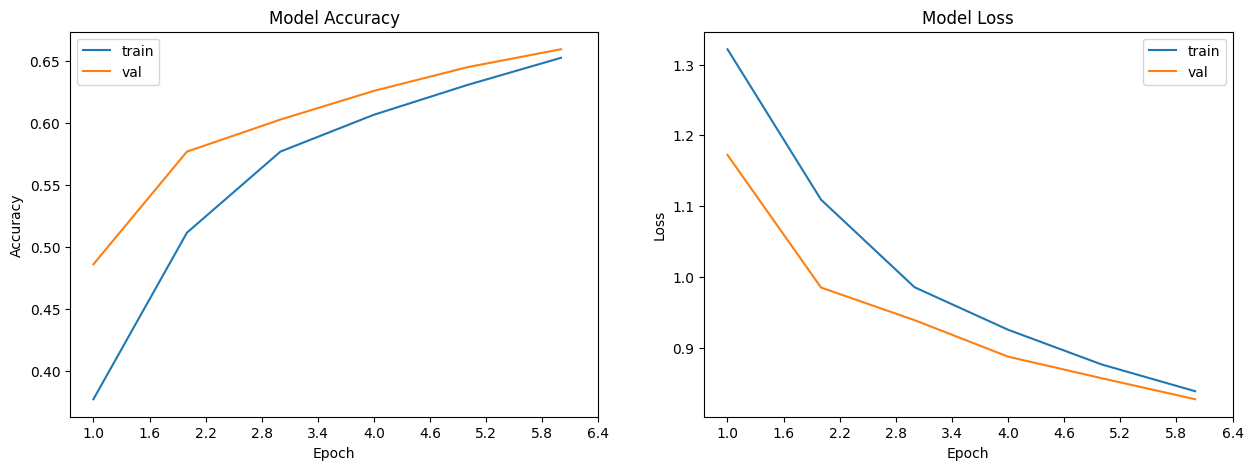

In [36]:
plot_model_history(model_info)

# Emotion Prediction

In [1]:
import numpy as np
from google.colab.patches import cv2_imshow
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# mode = "display"

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


def emotion_recog(frame):
    model.load_weights('model_weights_training_optimal.h5')

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
    emotion_dict = {0: "Angry", 1:"Happy", 2:"Sad", 3: "Calm"}

    # frame = cv2.imread("image1.jpg")
    # facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # for jupyter
    facecasc = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # for colab
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 255), 3)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # cv2_imshow(frame)
    return frame


1/1 [==============================] - 7s 7s/step


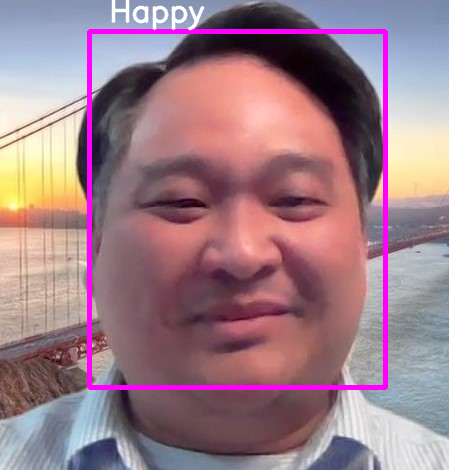

In [2]:
input = cv2.imread("happy.jpg")
output = emotion_recog(input)
cv2_imshow(output)

1/1 [==============================] - 0s 19ms/step


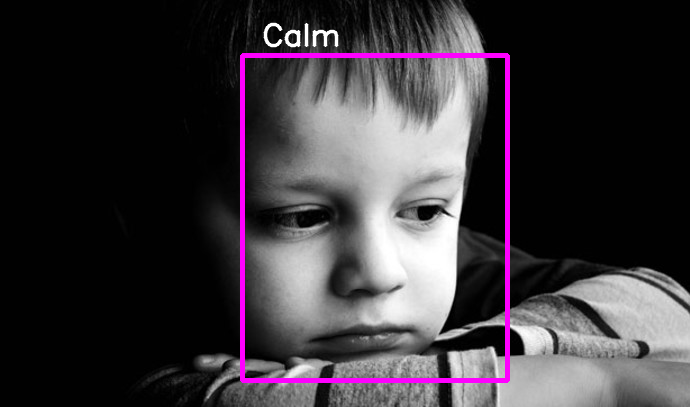

In [97]:
input = cv2.imread("calm.jpeg")
output = emotion_recog(input)
cv2_imshow(output)

1/1 [==============================] - 0s 17ms/step


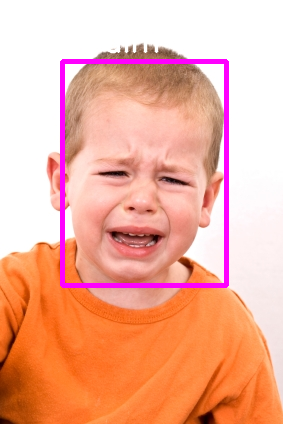

In [3]:
input = cv2.imread("sad.jpg")
output = emotion_recog(input)
cv2_imshow(output)